# Feature Engineering

##### Importación de librerías

In [11]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import re

##### Configuración de visualización

In [4]:
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

##### Carga de dataset

In [ ]:
csv_ubi = Path("../data/Titanic-Dataset-Canvas.csv")
df = pd.read_csv(csv_ubi)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##### Feature 1 - Título (Title)
Los títulos en los nombres reflejan estatus social, estado civil y edad aproximada.

In [12]:
def extract_title(name):
    if not isinstance(name, str):
        return "Unknown"

    match = re.search(r', \s*([^\.]+)\.', name)
    if not match:
        return "Unknown"
    
    return match.group(1).strip()

all_titles = df['Name'].apply(extract_title).unique()
print("Títulos únicos encontrados en el dataset:")
print(sorted(all_titles))

def create_title_mapping(titles):
    main_titles = {"Mr", "Mrs", "Miss", "Master"}
    
    variations = {
        "Mlle": "Miss",
        "Ms": "Miss",
        "Mme": "Mrs",
    }

    title_mapping = {}

    for title in titles:
        if title in main_titles:
            title_mapping[title] = title
        elif title in variations:
            title_mapping[title] = variations[title]
        else: title_mapping[title] = "Rare"

    return title_mapping

title_mapping = create_title_mapping(all_titles)
print("\nMapeo generado automáticamente:")
for original, mapped in sorted(title_mapping.items()):
    print(f"'{original}' -> '{mapped}'")

Títulos únicos encontrados en el dataset:
['Capt', 'Col', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master', 'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir', 'the Countess']

Mapeo generado automáticamente:
'Capt' -> 'Rare'
'Col' -> 'Rare'
'Don' -> 'Rare'
'Dr' -> 'Rare'
'Jonkheer' -> 'Rare'
'Lady' -> 'Rare'
'Major' -> 'Rare'
'Master' -> 'Master'
'Miss' -> 'Miss'
'Mlle' -> 'Miss'
'Mme' -> 'Mrs'
'Mr' -> 'Mr'
'Mrs' -> 'Mrs'
'Ms' -> 'Miss'
'Rev' -> 'Rare'
'Sir' -> 'Rare'
'the Countess' -> 'Rare'


In [13]:
def extract_and_map_title(name, mapping):
    if not isinstance(name, str):
        return "Unknown"
    
    match = re.search(r',\s*([^\.]+)\.', name)
    if not match:
        return "Unknown"
    
    title = match.group(1).strip()
    return mapping.get(title, "Rare")
df['Title'] = df['Name'].apply(lambda x: extract_and_map_title(x, title_mapping))

print("Distribución final de títulos:")
print(df['Title'].value_counts())

Distribución final de títulos:
Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64


##### Feature 2: Tamaño de la familia (Family Size)

El tamaño de la familia puede influir en la supervivencia, ya que las familias más grandes pueden tener patrones diferentes de supervivencia.

=== ANÁLISIS DE FEATURE: FAMILY SIZE ===
Rango: 1 - 11
Distribución:
FamilySize
1     537
2     161
3     102
4      29
5      15
6      22
7      12
8       6
11      7
Name: count, dtype: int64

Tasa de supervivencia por tamaño de familia:
            Count  Survival_Rate
FamilySize                      
1             537          0.304
2             161          0.553
3             102          0.578
4              29          0.724
5              15          0.200
6              22          0.136
7              12          0.333
8               6          0.000
11              7          0.000


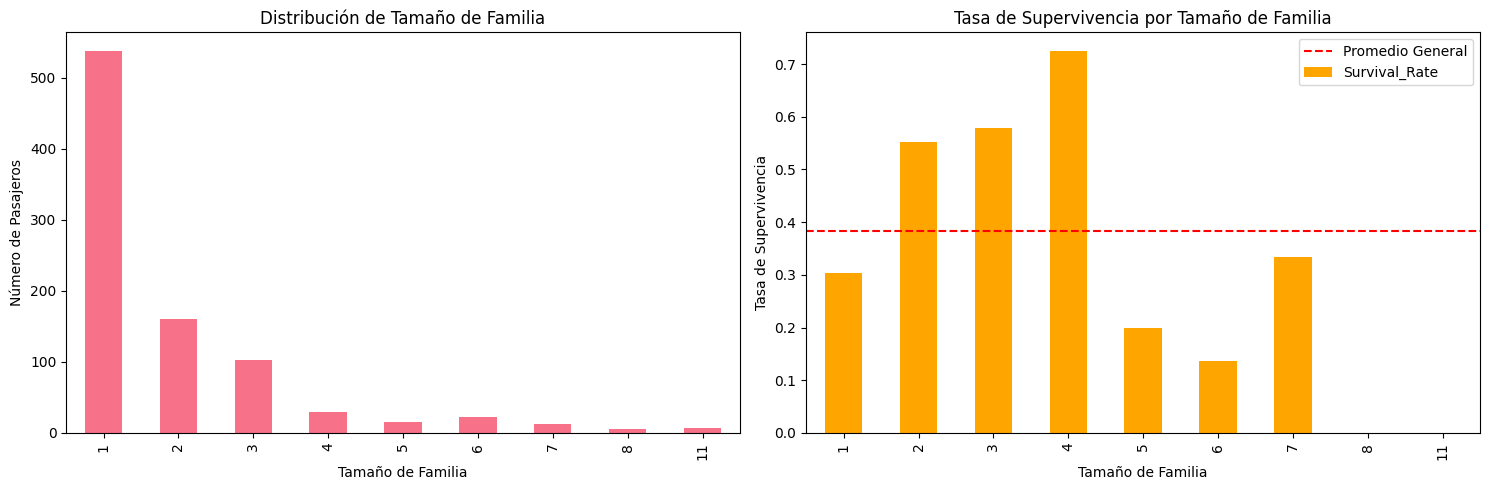

In [14]:
def compute_family_size(sibsp, parch):
    try:
        return int(sibsp) + int(parch) + 1
    except (ValueError, TypeError):
        s = pd.to_numeric(pd.Series([sibsp]), errors='coerce').iloc[0]
        p = pd.to_numeric(pd.Series([parch]), errors='coerce').iloc[0]
        s = 0 if pd.isna(s) else int(s)
        p = 0 if pd.isna(p) else int(p)
        return s + p + 1

df['FamilySize'] = [compute_family_size(s, p) for s, p in zip(df['SibSp'], df['Parch'])]

print("=== ANÁLISIS DE FEATURE: FAMILY SIZE ===")
print(f"Rango: {df['FamilySize'].min()} - {df['FamilySize'].max()}")
print(f"Distribución:")
family_counts = df['FamilySize'].value_counts().sort_index()
print(family_counts)

if 'Survived' in df.columns:
    survival_by_family = df.groupby('FamilySize')['Survived'].agg(['count', 'mean']).round(3)
    survival_by_family.columns = ['Count', 'Survival_Rate']
    print(f"\nTasa de supervivencia por tamaño de familia:")
    print(survival_by_family)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    family_counts.plot(kind='bar', ax=ax1)
    ax1.set_title('Distribución de Tamaño de Familia')
    ax1.set_xlabel('Tamaño de Familia')
    ax1.set_ylabel('Número de Pasajeros')

    survival_by_family['Survival_Rate'].plot(kind='bar', ax=ax2, color='orange')
    ax2.set_title('Tasa de Supervivencia por Tamaño de Familia')
    ax2.set_xlabel('Tamaño de Familia')
    ax2.set_ylabel('Tasa de Supervivencia')
    ax2.axhline(y=df['Survived'].mean(), color='red', linestyle='--', label='Promedio General')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

##### Feature 3: Viajero solo (isAlone)
Personas que viajan solas igualmente pueden tener diferentes patrones de supervivencia, y pueden ser más vulnerables en situaciones de emergencia.

=== ANÁLISIS DE FEATURE: IS ALONE ===
Distribución:
Viajan acompañados (0): 354
Viajan solos (1): 537
Porcentaje que viaja solo: 60.3%

Tasa de supervivencia por tipo de viaje:
            Count  Survival_Rate
Acompañado    354          0.506
Solo          537          0.304


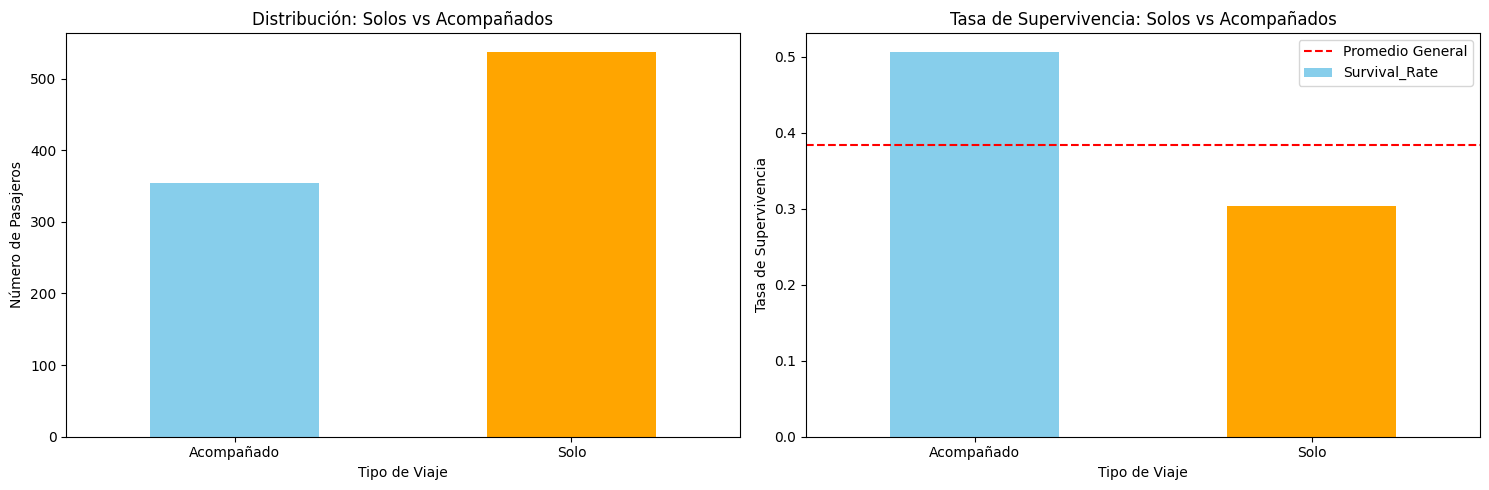


Verificación cruzada con FamilySize:
IsAlone       0    1  All
FamilySize               
1             0  537  537
2           161    0  161
3           102    0  102
4            29    0   29
5            15    0   15
6            22    0   22
7            12    0   12
8             6    0    6
11            7    0    7
All         354  537  891


In [15]:
def compute_is_alone(family_size):
    try:
        return 1 if int(family_size) == 1 else 0
    except (ValueError, TypeError):
        return 0

df['IsAlone'] = df['FamilySize'].apply(compute_is_alone)

print("=== ANÁLISIS DE FEATURE: IS ALONE ===")
print(f"Distribución:")
alone_counts = df['IsAlone'].value_counts().sort_index()
print(f"Viajan acompañados (0): {alone_counts[0]}")
print(f"Viajan solos (1): {alone_counts[1]}")
print(f"Porcentaje que viaja solo: {(alone_counts[1] / len(df)) * 100:.1f}%")

if 'Survived' in df.columns:
    survival_by_alone = df.groupby('IsAlone')['Survived'].agg(['count', 'mean']).round(3)
    survival_by_alone.columns = ['Count', 'Survival_Rate']
    survival_by_alone.index = ['Acompañado', 'Solo']
    print(f"\nTasa de supervivencia por tipo de viaje:")
    print(survival_by_alone)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    alone_counts.plot(kind='bar', ax=ax1, color=['skyblue', 'orange'])
    ax1.set_title('Distribución: Solos vs Acompañados')
    ax1.set_xlabel('Tipo de Viaje')
    ax1.set_ylabel('Número de Pasajeros')
    ax1.set_xticklabels(['Acompañado', 'Solo'], rotation=0)

    survival_by_alone['Survival_Rate'].plot(kind='bar', ax=ax2, color=['skyblue', 'orange'])
    ax2.set_title('Tasa de Supervivencia: Solos vs Acompañados')
    ax2.set_xlabel('Tipo de Viaje')
    ax2.set_ylabel('Tasa de Supervivencia')
    ax2.axhline(y=df['Survived'].mean(), color='red', linestyle='--', label='Promedio General')
    ax2.legend()
    ax2.set_xticklabels(['Acompañado', 'Solo'], rotation=0)
    
    plt.tight_layout()
    plt.show()

print(f"\nVerificación cruzada con FamilySize:")
cross_check = pd.crosstab(df['FamilySize'], df['IsAlone'], margins=True)
print(cross_check)

##### Feature 4: Grupos de edad (AgeGroup)
La población de diferentes edades igualmente pueden presentar un patrón de supervivencia diferente, ya que los niños, adultos y ancianos pueden tener diferentes niveles de vulnerabilidad y habilidades ante situaciones de emergencia.

=== ANÁLISIS DE FEATURE: AGE GROUP ===
Distribución:
AgeGroup
YoungAdult    271
Adult         215
Unknown       177
MidAge         89
Child          54
Teen           45
Senior         26
Infant         14
Name: count, dtype: int64

Estadísticas de edad por grupo:
            count   min   max  mean
AgeGroup                           
Adult         215  30.0  44.0  35.7
Child          54   2.0  11.0   5.6
Infant         14   0.4   1.0   0.9
MidAge         89  45.0  59.0  50.4
Senior         26  60.0  80.0  65.1
Teen           45  12.0  17.0  15.7
Unknown         0   NaN   NaN   NaN
YoungAdult    271  18.0  29.0  23.4

Tasa de supervivencia por grupo de edad:
            Count  Survival_Rate
AgeGroup                        
Infant         14          0.857
Child          54          0.500
Teen           45          0.489
Adult         215          0.423
MidAge         89          0.404
YoungAdult    271          0.351
Unknown       177          0.294
Senior         26          0.269


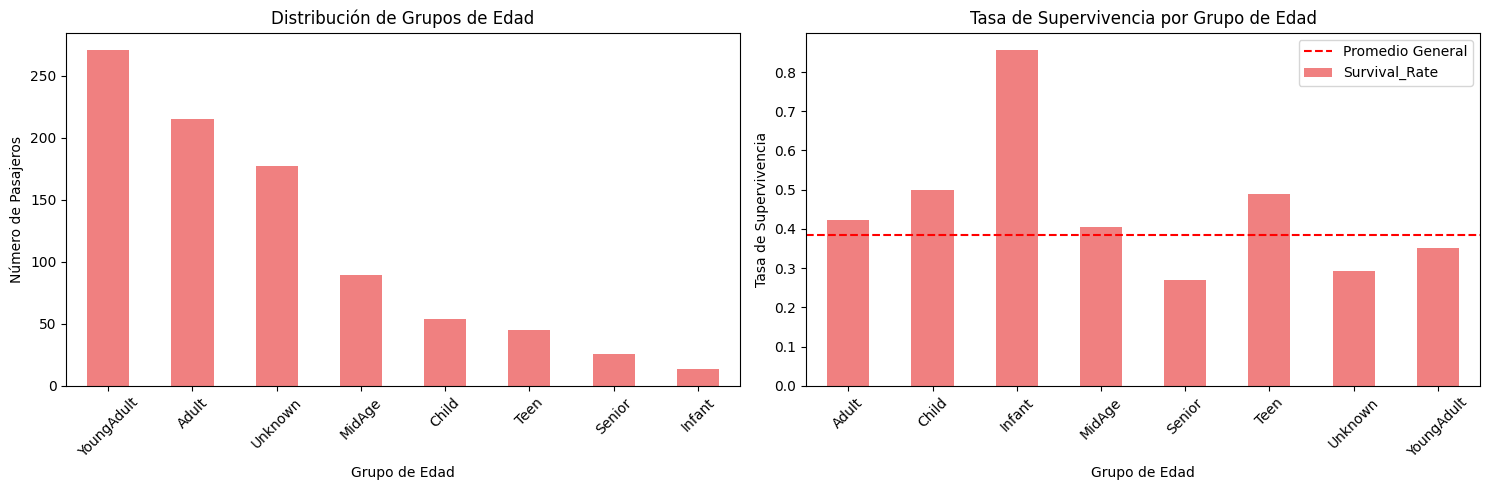


Análisis de valores faltantes en Age:
Valores faltantes: 177 (19.9%)
Asignados a 'Unknown': 177


In [16]:
def age_to_group(age):
    age_numeric = pd.to_numeric(pd.Series([age]), errors='coerce').iloc[0]
    
    if pd.isna(age_numeric):
        return "Unknown"
    
    if age_numeric < 2:
        return "Infant"
    elif age_numeric < 12:
        return "Child"
    elif age_numeric < 18:
        return "Teen"
    elif age_numeric < 30:
        return "YoungAdult"
    elif age_numeric < 45:
        return "Adult"
    elif age_numeric < 60:
        return "MidAge"
    else:
        return "Senior"

df['AgeGroup'] = df['Age'].apply(age_to_group)

print("=== ANÁLISIS DE FEATURE: AGE GROUP ===")
print(f"Distribución:")
age_group_counts = df['AgeGroup'].value_counts()
print(age_group_counts)

print(f"\nEstadísticas de edad por grupo:")
age_stats = df.groupby('AgeGroup')['Age'].agg(['count', 'min', 'max', 'mean']).round(1)
print(age_stats)

if 'Survived' in df.columns:
    survival_by_age_group = df.groupby('AgeGroup')['Survived'].agg(['count', 'mean']).round(3)
    survival_by_age_group.columns = ['Count', 'Survival_Rate']
    print(f"\nTasa de supervivencia por grupo de edad:")
    print(survival_by_age_group.sort_values('Survival_Rate', ascending=False))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    age_group_counts.plot(kind='bar', ax=ax1, color='lightcoral')
    ax1.set_title('Distribución de Grupos de Edad')
    ax1.set_xlabel('Grupo de Edad')
    ax1.set_ylabel('Número de Pasajeros')
    ax1.tick_params(axis='x', rotation=45)

    survival_by_age_group['Survival_Rate'].plot(kind='bar', ax=ax2, color='lightcoral')
    ax2.set_title('Tasa de Supervivencia por Grupo de Edad')
    ax2.set_xlabel('Grupo de Edad')
    ax2.set_ylabel('Tasa de Supervivencia')
    ax2.axhline(y=df['Survived'].mean(), color='red', linestyle='--', label='Promedio General')
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

print(f"\nAnálisis de valores faltantes en Age:")
print(f"Valores faltantes: {df['Age'].isna().sum()} ({(df['Age'].isna().sum()/len(df))*100:.1f}%)")
print(f"Asignados a 'Unknown': {(df['AgeGroup'] == 'Unknown').sum()}")

##### Feature 5: Tarifa por persona (FarePerPerson)
Nos apoyaría en la definición de grupos socioeconómicos entre la población y con la posibilidad de saber en cuál de las zonas del barco se encontraba cada uno.

=== ANÁLISIS DE FEATURE: FARE PER PERSON ===
Estadísticas descriptivas:
count    891.00
mean      17.79
std       21.22
min        0.00
25%        7.76
50%        8.85
75%       24.29
max      221.78
Name: FarePerPerson, dtype: float64

Comparación Fare vs FarePerPerson:
       Fare_Original  FarePerPerson
count         891.00         891.00
mean           32.20          17.79
std            49.69          21.22
min             0.00           0.00
25%             7.91           7.76
50%            14.45           8.85
75%            31.00          24.29
max           512.33         221.78

Ejemplos de tickets compartidos:
                                                 Name   Ticket     Fare  \
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)   113803  53.1000   
7                      Palsson, Master. Gosta Leonard   349909  21.0750   
8   Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)   347742  11.1333   
9                 Nasser, Mrs. Nicholas (Adele Achem)   237736  30.070

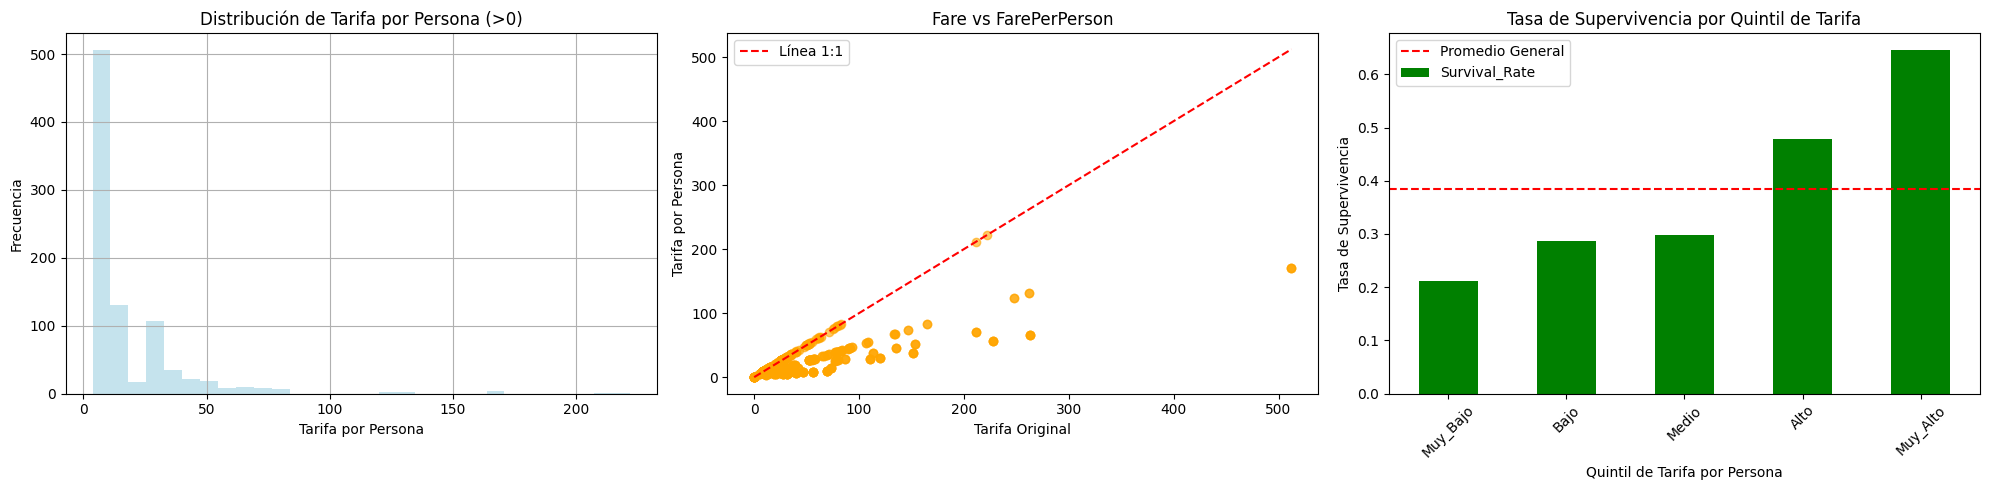


Análisis de tickets compartidos:
   Personas_por_Ticket  Num_Tickets
0                    1          547
1                    2          188
2                    3           63
3                    4           44
4                    5           10
5                    6           18
6                    7           21


In [18]:
def compute_ticket_frequency(df):
    return df['Ticket'].value_counts().to_dict()

def compute_fare_per_person(fare, ticket, ticket_freq_dict):
    try:
        fare_numeric = pd.to_numeric(pd.Series([fare]), errors='coerce').iloc[0]

        if pd.isna(fare_numeric) or fare_numeric == 0:
            return 0.0

        people_sharing = ticket_freq_dict.get(ticket, 1)

        return fare_numeric / people_sharing
        
    except Exception:
        return 0.0

ticket_frequencies = compute_ticket_frequency(df)

df['FarePerPerson'] = [
    compute_fare_per_person(fare, ticket, ticket_frequencies) 
    for fare, ticket in zip(df['Fare'], df['Ticket'])
]

print("=== ANÁLISIS DE FEATURE: FARE PER PERSON ===")
print(f"Estadísticas descriptivas:")
fare_stats = df['FarePerPerson'].describe().round(2)
print(fare_stats)

print(f"\nComparación Fare vs FarePerPerson:")
comparison = pd.DataFrame({
    'Fare_Original': df['Fare'].describe().round(2),
    'FarePerPerson': df['FarePerPerson'].describe().round(2)
})
print(comparison)

print(f"\nEjemplos de tickets compartidos:")
shared_tickets = df[df['Ticket'].map(ticket_frequencies) > 1][['Name', 'Ticket', 'Fare', 'FarePerPerson']].head(10)
print(shared_tickets)

print(f"\nAnálisis de calidad:")
print(f"Valores cero en Fare original: {(df['Fare'] == 0).sum()}")
print(f"Valores cero en FarePerPerson: {(df['FarePerPerson'] == 0).sum()}")
print(f"Valores faltantes en Fare: {df['Fare'].isna().sum()}")
print(f"Valores faltantes en FarePerPerson: {df['FarePerPerson'].isna().sum()}")

if 'Survived' in df.columns:
    fare_non_zero = df[df['FarePerPerson'] > 0]['FarePerPerson']
    
    if len(fare_non_zero) > 0:
        df['FarePerPerson_Quintile'] = pd.qcut(
            df['FarePerPerson'].rank(method='first'), 
            q=5, 
            labels=['Muy_Bajo', 'Bajo', 'Medio', 'Alto', 'Muy_Alto'],
            duplicates='drop'
        )
        
        survival_by_fare = df.groupby('FarePerPerson_Quintile')['Survived'].agg(['count', 'mean']).round(3)
        survival_by_fare.columns = ['Count', 'Survival_Rate']
        print(f"\nTasa de supervivencia por quintil de tarifa por persona:")
        print(survival_by_fare)
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
        
        df[df['FarePerPerson'] > 0]['FarePerPerson'].hist(bins=30, ax=ax1, color='lightblue', alpha=0.7)
        ax1.set_title('Distribución de Tarifa por Persona (>0)')
        ax1.set_xlabel('Tarifa por Persona')
        ax1.set_ylabel('Frecuencia')

        ax2.scatter(df['Fare'], df['FarePerPerson'], alpha=0.6, color='orange')
        ax2.plot([0, df['Fare'].max()], [0, df['Fare'].max()], 'r--', label='Línea 1:1')
        ax2.set_xlabel('Tarifa Original')
        ax2.set_ylabel('Tarifa por Persona')
        ax2.set_title('Fare vs FarePerPerson')
        ax2.legend()

        if 'FarePerPerson_Quintile' in df.columns:
            survival_by_fare['Survival_Rate'].plot(kind='bar', ax=ax3, color='green')
            ax3.set_title('Tasa de Supervivencia por Quintil de Tarifa')
            ax3.set_xlabel('Quintil de Tarifa por Persona')
            ax3.set_ylabel('Tasa de Supervivencia')
            ax3.axhline(y=df['Survived'].mean(), color='red', linestyle='--', label='Promedio General')
            ax3.legend()
            ax3.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()

print(f"\nAnálisis de tickets compartidos:")
ticket_sharing_analysis = pd.DataFrame({
    'Personas_por_Ticket': df['Ticket'].map(ticket_frequencies),
    'Count': df['Ticket'].map(ticket_frequencies)
}).groupby('Personas_por_Ticket').size().reset_index()
ticket_sharing_analysis.columns = ['Personas_por_Ticket', 'Num_Tickets']
print(ticket_sharing_analysis.head(10))

##### Feature 6: Frecuencia de Ticket (TicketFrequency)

Nos indica cuántas personas comparten el mismo ticket, lo que puede revelar grupos familiares o de viaje que no son detectados por SibSp/Parch.

=== ANÁLISIS DE FEATURE: TICKET FREQUENCY ===
Estadísticas descriptivas:
count    891.00
mean       1.79
std        1.36
min        1.00
25%        1.00
50%        1.00
75%        2.00
max        7.00
Name: TicketFrequency, dtype: float64

Distribución de frecuencias de ticket:
TicketFrequency
1    547
2    188
3     63
4     44
5     10
6     18
7     21
Name: count, dtype: int64

Ejemplos de tickets compartidos:

Tickets compartidos por 2 personas:
                                        Name  Ticket  FamilySize  TicketFrequency
Futrelle, Mrs. Jacques Heath (Lily May Peel)  113803           2                2
         Nasser, Mrs. Nicholas (Adele Achem)  237736           2                2
             Sandstrom, Miss. Marguerite Rut PP 9549           3                2

Tickets compartidos por 3 personas:
                                             Name        Ticket  FamilySize  TicketFrequency
Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)        347742           3            

KeyError: "'purples' is not a known colormap name"

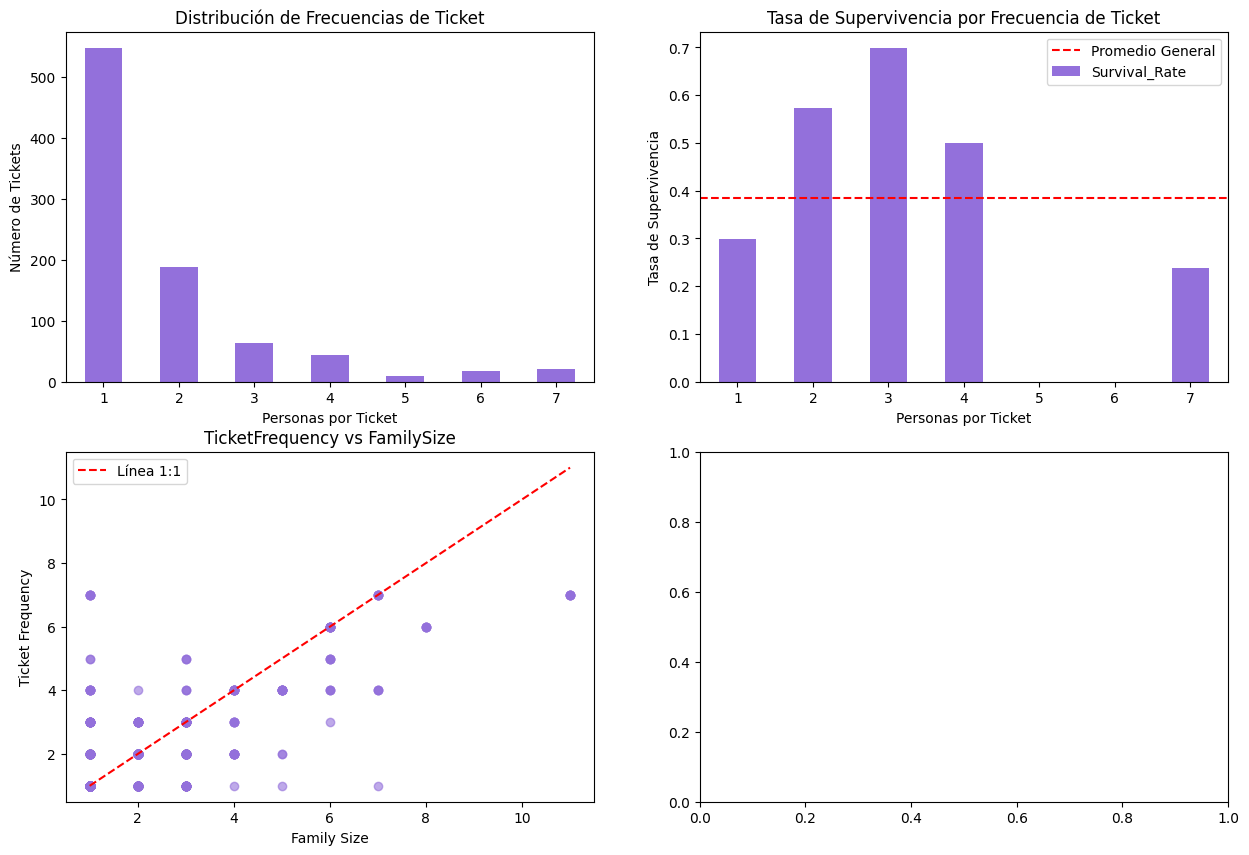

In [ ]:
def compute_ticket_frequency_feature(ticket, ticket_freq_dict):
    try:
        return ticket_freq_dict.get(ticket, 1)
    except Exception:
        return 1

df['TicketFrequency'] = df['Ticket'].map(ticket_frequencies)

print("=== ANÁLISIS DE FEATURE: TICKET FREQUENCY ===")
print(f"Estadísticas descriptivas:")
ticket_freq_stats = df['TicketFrequency'].describe().round(2)
print(ticket_freq_stats)

print(f"\nDistribución de frecuencias de ticket:")
ticket_freq_counts = df['TicketFrequency'].value_counts().sort_index()
print(ticket_freq_counts.head(10))

print(f"\nEjemplos de tickets compartidos:")
for freq in [2, 3, 4, 5]:
    if freq in df['TicketFrequency'].values:
        examples = df[df['TicketFrequency'] == freq][['Name', 'Ticket', 'FamilySize', 'TicketFrequency']].head(3)
        print(f"\nTickets compartidos por {freq} personas:")
        print(examples.to_string(index=False))

print(f"\nComparación TicketFrequency vs FamilySize:")
comparison_table = pd.crosstab(df['TicketFrequency'], df['FamilySize'], margins=True)
print(comparison_table)

print(f"\nAnálisis de discrepancias (TicketFreq != FamilySize):")
discrepancies = df[df['TicketFrequency'] != df['FamilySize']]
print(f"Casos donde difieren: {len(discrepancies)} ({(len(discrepancies)/len(df))*100:.1f}%)")

if len(discrepancies) > 0:
    print(f"\nEjemplos de discrepancias:")
    disc_examples = discrepancies[['Name', 'Ticket', 'SibSp', 'Parch', 'FamilySize', 'TicketFrequency']].head(5)
    print(disc_examples.to_string(index=False))

if 'Survived' in df.columns:
    survival_by_ticket_freq = df.groupby('TicketFrequency')['Survived'].agg(['count', 'mean']).round(3)
    survival_by_ticket_freq.columns = ['Count', 'Survival_Rate']
    print(f"\nTasa de supervivencia por frecuencia de ticket:")
    print(survival_by_ticket_freq.head(10))
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    ticket_freq_counts.head(10).plot(kind='bar', ax=ax1, color='mediumpurple')
    ax1.set_title('Distribución de Frecuencias de Ticket')
    ax1.set_xlabel('Personas por Ticket')
    ax1.set_ylabel('Número de Tickets')
    ax1.tick_params(axis='x', rotation=0)
    
    survival_by_ticket_freq['Survival_Rate'].head(8).plot(kind='bar', ax=ax2, color='mediumpurple')
    ax2.set_title('Tasa de Supervivencia por Frecuencia de Ticket')
    ax2.set_xlabel('Personas por Ticket')
    ax2.set_ylabel('Tasa de Supervivencia')
    ax2.axhline(y=df['Survived'].mean(), color='red', linestyle='--', label='Promedio General')
    ax2.legend()
    ax2.tick_params(axis='x', rotation=0)
    
    ax3.scatter(df['FamilySize'], df['TicketFrequency'], alpha=0.6, color='mediumpurple')
    ax3.plot([1, df['FamilySize'].max()], [1, df['FamilySize'].max()], 'r--', label='Línea 1:1')
    ax3.set_xlabel('Family Size')
    ax3.set_ylabel('Ticket Frequency')
    ax3.set_title('TicketFrequency vs FamilySize')
    ax3.legend()
    
    comparison_pct = pd.crosstab(df['TicketFrequency'], df['FamilySize'], normalize='index').round(2)
    sns.heatmap(comparison_pct.iloc[:8, :8], annot=True, cmap='Purples', ax=ax4, 
                cbar_kws={'label': 'Proporción'})
    ax4.set_title('Heatmap: TicketFreq vs FamilySize')
    ax4.set_xlabel('Family Size')
    ax4.set_ylabel('Ticket Frequency')
    
    plt.tight_layout()
    plt.show()

print(f"\nAnálisis de calidad:")
print(f"Valores faltantes: {df['TicketFrequency'].isna().sum()}")
print(f"Valores únicos: {df['TicketFrequency'].nunique()}")
print(f"Rango: {df['TicketFrequency'].min()} - {df['TicketFrequency'].max()}")

def categorize_ticket_frequency(freq):
    if freq == 1:
        return "Individual"
    elif freq == 2:
        return "Pareja"
    elif freq <= 4:
        return "Grupo_Pequeño"
    elif freq <= 6:
        return "Grupo_Mediano"
    else:
        return "Grupo_Grande"

df['TicketFreq_Category'] = df['TicketFrequency'].apply(categorize_ticket_frequency)

print(f"\nDistribución por categorías de ticket:")
ticket_cat_counts = df['TicketFreq_Category'].value_counts()
print(ticket_cat_counts)

if 'Survived' in df.columns:
    survival_by_ticket_cat = df.groupby('TicketFreq_Category')['Survived'].agg(['count', 'mean']).round(3)
    survival_by_ticket_cat.columns = ['Count', 'Survival_Rate']
    print(f"\nTasa de supervivencia por categoría de ticket:")
    print(survival_by_ticket_cat.sort_values('Survival_Rate', ascending=False))